In [65]:
# Import required modules
import pandas as pd
import numpy as np
from ds_dev_tools.awstools import FileDoggo, S3Location
import plotly.express as px
import time
import boto3

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [66]:
# Define date range for queries
start_datetime = '2024-11-20 00:00:00'
end_datetime = '2024-11-26 23:59:59'
start_year = 2024
end_year = 2024
start_month = 11
end_month = 11
start_day = 20
end_day = 26

In [67]:
# Initialize Athena client
athena_client = boto3.client('athena')

output_location = 's3://production-datalake-stac-datalakeskipprbucket4a91-jqc93kmxmqsm/output/dev/'

# Method to execute athena query
def query_athena(query_string):
    response = athena_client.start_query_execution(
        QueryString=query_string,
        QueryExecutionContext={
            'Database': 'datalake'
        },
        ResultConfiguration={
            'OutputLocation': output_location
        }
    )

    # Get the QueryExecutionId to check the query status and get results
    query_execution_id = response['QueryExecutionId']
    query_status = 'QUEUED'

    while query_status in ['RUNNING', 'QUEUED']:
        query_status_response = athena_client.get_query_execution(
            QueryExecutionId=query_execution_id
        )
        query_status = query_status_response['QueryExecution']['Status']['State']

        if query_status == 'FAILED':
            raise Exception("Athena query failed.")

        # Add a delay so we don't overwhelm the service
        if query_status in ['RUNNING', 'QUEUED']:
            time.sleep(5)


    with FileDoggo(S3Location(output_location).join(f'{query_execution_id}.csv')) as f:
        df = pd.read_csv(f)

    return df

In [68]:
# Define and execute the Athena queries
trip_start_end_query = f'''
    SELECT
        detail_imei AS imei,
        detail_registration AS truck_registration,
        detail_docket_id,
        detail_start_time AS prediction_tripstart_datetime_utc,
        detail_end_time AS prediction_tripend_datetime_utc
    FROM "order_trip_end"
    WHERE year BETWEEN {start_year} AND {end_year}
        AND month BETWEEN {start_month} AND {end_month}
'''

trip_start_end_df = query_athena(trip_start_end_query)

delivery_start_end_query = f'''
    SELECT
        detail_imei AS imei,
        detail_registration AS truck_registration,
        detail_docket_id AS detail_docket_id_str,
        detail_start_time AS delivery_start_datetime_utc,
        detail_end_time AS delivery_end_datetime_utc
    FROM "order_delivery_end"
    WHERE year BETWEEN {start_year} AND {end_year}
        AND month BETWEEN {start_month} AND {end_month}
'''

delivery_start_end_df = query_athena(delivery_start_end_query)

device_data_query = f'''
    SELECT
        imei,
        truck_registration,
        system_datetime_posix_utc_seconds,
        system_cpu_temperature_degc,
        drum_data_valid,
        drum_vector_rpm AS drum_speed_mean_rpm,
        system_operating_mode,
        pressure_a_bar_data_valid,
        pressure_a_bar_mean,
        pressure_b_bar_data_valid,
        pressure_b_bar_mean,
        temperature_module_data_valid,
        temperature_module_surface_temperature_degc,
        temperature_module_speed_mean_rpm,
        truck_gearbox_ratio AS calibration_gearbox_ratio,
        truck_id,
        truck_motor_displacement_cm3 AS calibration_motor_displacement_cm3,
        truck_motor_efficiency AS calibration_motor_efficiency,
        truck_rmc_provider,
        water_flowmeter_data_valid AS water_valid,
        water_flowmeter_total_volume_m3 AS water_cumu_vol,
        water_flowmeter_flow_rate_m3_hr
    FROM "datalake"."device_data"
    WHERE year BETWEEN {start_year} AND {end_year}
        AND month BETWEEN {start_month} AND {end_month}
        AND system_datetime_posix_utc_seconds > CAST('{start_datetime}' AS timestamp)
        AND system_datetime_posix_utc_seconds < CAST('{end_datetime}' AS timestamp)
    ORDER BY system_datetime_posix_utc_seconds ASC
'''

device_df = query_athena(device_data_query)

In [69]:
# Convert to datetime
device_df['datetime_utc'] = pd.to_datetime(device_df.system_datetime_posix_utc_seconds).dt.tz_localize('utc')
trip_start_end_df['prediction_tripstart_datetime_utc'] = pd.to_datetime(trip_start_end_df.prediction_tripstart_datetime_utc).dt.tz_localize('utc')
trip_start_end_df['prediction_tripend_datetime_utc'] = pd.to_datetime(trip_start_end_df.prediction_tripend_datetime_utc).dt.tz_localize('utc')
delivery_start_end_df['delivery_start_datetime_utc'] = pd.to_datetime(delivery_start_end_df.delivery_start_datetime_utc).dt.tz_localize('utc')
delivery_start_end_df['delivery_end_datetime_utc'] = pd.to_datetime(delivery_start_end_df.delivery_end_datetime_utc).dt.tz_localize('utc')

# Filter to specific dates
trip_start_end_df = trip_start_end_df[
    (trip_start_end_df.prediction_tripstart_datetime_utc >= start_datetime) &
    (trip_start_end_df.prediction_tripstart_datetime_utc <= end_datetime)
]
device_df = device_df[
    (device_df.datetime_utc >= start_datetime) &
    (device_df.datetime_utc <= end_datetime)
]
delivery_start_end_df = delivery_start_end_df[
    (delivery_start_end_df.delivery_start_datetime_utc >= start_datetime) &
    (delivery_start_end_df.delivery_end_datetime_utc <= end_datetime)
]

In [70]:
delivery_start_end_df.head()

,imei,truck_registration,detail_docket_id_str,delivery_start_datetime_utc,delivery_end_datetime_utc
31,352247631511533,PX70LNR,Cemex--1026194030,2024-11-20 14:51:10+00:00,2024-11-20 15:41:47+00:00
32,352247631514107,KX67RKZ,Cemex--1026193452,2024-11-20 14:05:21+00:00,2024-11-20 15:42:22+00:00
33,356129320310383,FS099ZD,Holcim--4426013209,2024-11-20 14:29:49+00:00,2024-11-20 15:43:23+00:00
34,356129320102079,PO66VCA,Cemex--1026194150,2024-11-20 14:53:08+00:00,2024-11-20 15:43:29+00:00
35,356129320194860,FT110NM,Holcim--4423003753,2024-11-20 13:19:35+00:00,2024-11-20 15:44:34+00:00


In [71]:
# attache trip details to device data
delivery_start_end_df['detail_docket_id'] = delivery_start_end_df.detail_docket_id_str
dockets = delivery_start_end_df.detail_docket_id.unique()

trip_data_df = device_df.copy()
trip_data_df['docket_id'] = None
trip_data_df['trip_start'] = None
trip_data_df['trip_end'] = None

for docket in dockets:
    row = delivery_start_end_df[delivery_start_end_df.detail_docket_id == docket].iloc[0]
    docket_id = row.detail_docket_id
    truck_registration = row.truck_registration
    trip_start = row.delivery_start_datetime_utc
    trip_end = row.delivery_end_datetime_utc
    mask = (trip_data_df.truck_registration == truck_registration) & (trip_data_df.datetime_utc >= trip_start) & (trip_data_df.datetime_utc <= trip_end)
    trip_data_df.loc[mask, 'docket_id'] = docket_id
    trip_data_df.loc[mask, 'trip_start'] = trip_start
    trip_data_df.loc[mask, 'trip_end'] = trip_end

In [72]:
trip_data_df[(trip_data_df.docket_id.isnull()==False) & (trip_data_df.system_operating_mode == 'Measuring Mode Engine Off')].head()

,imei,truck_registration,system_datetime_posix_utc_seconds,system_cpu_temperature_degc,drum_data_valid,drum_speed_mean_rpm,system_operating_mode,pressure_a_bar_data_valid,pressure_a_bar_mean,pressure_b_bar_data_valid,pressure_b_bar_mean,temperature_module_data_valid,temperature_module_surface_temperature_degc,temperature_module_speed_mean_rpm,calibration_gearbox_ratio,truck_id,calibration_motor_displacement_cm3,calibration_motor_efficiency,truck_rmc_provider,water_valid,water_cumu_vol,water_flowmeter_flow_rate_m3_hr,datetime_utc,docket_id,trip_start,trip_end
95909,356129320264978,FN108NJ,2024-11-20 05:36:57.000,27.0,0,8.953,Measuring Mode Engine Off,1,174.74,1,21.42,1,13.52,-8.953,131.0,466.0,90.0,NaN,Holcim,1,112.093,0.0,2024-11-20 05:36:57+00:00,Holcim--4464005167,2024-11-20 05:36:53+00:00,2024-11-20 07:11:15+00:00
95959,356129320264978,FN108NJ,2024-11-20 05:37:07.000,26.0,0,8.964,Measuring Mode Engine Off,1,172.57,1,21.39,1,13.71,-8.964,131.0,466.0,90.0,NaN,Holcim,1,112.093,0.0,2024-11-20 05:37:07+00:00,Holcim--4464005167,2024-11-20 05:36:53+00:00,2024-11-20 07:11:15+00:00
96020,356129320264978,FN108NJ,2024-11-20 05:37:17.000,26.0,0,8.967,Measuring Mode Engine Off,1,171.52,1,21.40,1,13.93,-8.967,131.0,466.0,90.0,NaN,Holcim,1,112.093,0.0,2024-11-20 05:37:17+00:00,Holcim--4464005167,2024-11-20 05:36:53+00:00,2024-11-20 07:11:15+00:00
96087,356129320264978,FN108NJ,2024-11-20 05:37:28.000,27.0,0,8.956,Measuring Mode Engine Off,1,173.61,1,21.41,1,14.11,-8.956,131.0,466.0,90.0,NaN,Holcim,1,112.093,0.0,2024-11-20 05:37:28+00:00,Holcim--4464005167,2024-11-20 05:36:53+00:00,2024-11-20 07:11:15+00:00
96143,356129320264978,FN108NJ,2024-11-20 05:37:38.000,27.0,0,8.888,Measuring Mode Engine Off,1,177.24,1,21.36,1,14.25,-8.888,131.0,466.0,90.0,NaN,Holcim,1,112.093,0.0,2024-11-20 05:37:38+00:00,Holcim--4464005167,2024-11-20 05:36:53+00:00,2024-11-20 07:11:15+00:00


In [ ]:
# Calculate time spent in `Measuring Mode Engine Off` when on a delivery
dockets = trip_data_df.docket_id.unique()
trip_data_df = trip_data_df.sort_values(['truck_registration', 'datetime_utc'])
engine_off = 'Measuring Mode Engine Off'

for docket in dockets:
    mask = (trip_data_df.docket_id == docket)
    trip_data_df.loc[mask, 'prev_system_operating_mode'] = trip_data_df[mask].system_operating_mode.shift(1)
    trip_data_df.loc[
        mask
        & (trip_data_df.system_operating_mode == engine_off)
        & (trip_data_df.prev_system_operating_mode != engine_off)
        , 'engine_off_start_flag'
    ] = 1
    trip_data_df.loc[
        mask
        & (trip_data_df.system_operating_mode != engine_off)
        & (trip_data_df.prev_system_operating_mode == engine_off)
        , 'engine_off_end_flag'
    ] = 1

In [74]:
engine_off_delivery_df = trip_data_df[(trip_data_df.docket_id.isnull()==False) & (trip_data_df.system_operating_mode == engine_off)]
engine_off_delivery_df['engine_off_start_flag'] = engine_off_delivery_df.engine_off_start_flag.fillna(0)
engine_off_delivery_df['engine_off_section_id'] = engine_off_delivery_df.engine_off_start_flag.cumsum()
engine_off_delivery_df.head()

C:\Users\Nicole\AppData\Local\Temp\ipykernel_32816\2149200112.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nicole\AppData\Local\Temp\ipykernel_32816\2149200112.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,imei,truck_registration,system_datetime_posix_utc_seconds,system_cpu_temperature_degc,drum_data_valid,drum_speed_mean_rpm,system_operating_mode,pressure_a_bar_data_valid,pressure_a_bar_mean,pressure_b_bar_data_valid,pressure_b_bar_mean,temperature_module_data_valid,temperature_module_surface_temperature_degc,temperature_module_speed_mean_rpm,calibration_gearbox_ratio,truck_id,calibration_motor_displacement_cm3,calibration_motor_efficiency,truck_rmc_provider,water_valid,water_cumu_vol,water_flowmeter_flow_rate_m3_hr,datetime_utc,docket_id,trip_start,trip_end,prev_system_operating_mode,engine_off_start_flag,engine_off_end_flag,engine_off_section_id
6403695,359206105984504,BJ17WUY,2024-11-26 11:07:04.000,26.0,0,-0.087,Measuring Mode Engine Off,1,6.35,1,3.23,1,13.85,-0.087,120.3,240.0,89.1,NaN,Cemex,1,84.580,0.0,2024-11-26 11:07:04+00:00,Cemex--1026264747,2024-11-26 10:24:38+00:00,2024-11-26 11:49:32+00:00,Measuring,1.0,NaN,1.0
4740941,355939982565798,BP24LGC,2024-11-25 07:38:22.000,25.0,0,0.000,Measuring Mode Engine Off,1,0.11,1,0.00,0,0.00,0.000,7.8,488.0,1340.0,NaN,Cemex,1,20.844,0.0,2024-11-25 07:38:22+00:00,Cemex--1026239030,2024-11-25 07:38:16+00:00,2024-11-25 10:01:50+00:00,None,1.0,NaN,2.0
4741205,355939982565798,BP24LGC,2024-11-25 07:38:32.000,25.0,0,0.000,Measuring Mode Engine Off,1,0.11,1,0.00,0,0.00,0.000,7.8,488.0,1340.0,NaN,Cemex,1,20.844,0.0,2024-11-25 07:38:32+00:00,Cemex--1026239030,2024-11-25 07:38:16+00:00,2024-11-25 10:01:50+00:00,Measuring Mode Engine Off,0.0,NaN,2.0
4741455,355939982565798,BP24LGC,2024-11-25 07:38:42.000,25.0,0,0.000,Measuring Mode Engine Off,1,0.11,1,0.00,0,0.00,0.000,7.8,488.0,1340.0,NaN,Cemex,1,20.844,0.0,2024-11-25 07:38:42+00:00,Cemex--1026239030,2024-11-25 07:38:16+00:00,2024-11-25 10:01:50+00:00,Measuring Mode Engine Off,0.0,NaN,2.0
4741737,355939982565798,BP24LGC,2024-11-25 07:38:53.000,25.0,0,0.000,Measuring Mode Engine Off,1,0.11,1,0.00,0,0.00,0.000,7.8,488.0,1340.0,NaN,Cemex,1,20.844,0.0,2024-11-25 07:38:53+00:00,Cemex--1026239030,2024-11-25 07:38:16+00:00,2024-11-25 10:01:50+00:00,Measuring Mode Engine Off,0.0,NaN,2.0


In [75]:
engine_off_summary_df = engine_off_delivery_df[
    ['docket_id', 'engine_off_section_id', 'datetime_utc']
].groupby(['docket_id', 'engine_off_section_id']).agg({'datetime_utc': ['min', 'max']}).droplevel(axis=1, level=0).reset_index()
engine_off_summary_df = engine_off_summary_df.rename(columns={'min': 'engine_off_start', 'max': 'engine_off_end'})
engine_off_summary_df['engine_off_duration_minutes'] = (engine_off_summary_df.engine_off_end - engine_off_summary_df.engine_off_start).dt.total_seconds() / 60

In [77]:
max_engine_off_duration = engine_off_summary_df.engine_off_duration_minutes.max()
print(f'Maximum engine off duration: {max_engine_off_duration} minutes')

Maximum engine off duration: 832.6833333333333 minutes


Checked the below deliveries and these are mostly due to the delivery and/or trip end times not being right. 

The below engine off sections occured outside of a delivery.

In [ ]:
# Examples to check manually
engine_off_summary_df[engine_off_summary_df.engine_off_duration_minutes > 50]

,docket_id,engine_off_section_id,engine_off_start,engine_off_end,engine_off_duration_minutes
36,Cemex--1026192865,288.0,2024-11-20 14:20:45+00:00,2024-11-20 15:53:30+00:00,92.750000
40,Cemex--1026193368,530.0,2024-11-20 15:09:24+00:00,2024-11-20 16:09:15+00:00,59.850000
41,Cemex--1026193368,531.0,2024-11-20 18:43:31+00:00,2024-11-20 19:43:22+00:00,59.850000
51,Cemex--1026199097,202.0,2024-11-21 11:06:02+00:00,2024-11-21 12:05:54+00:00,59.866667
56,Cemex--1026200487,332.0,2024-11-21 08:20:37+00:00,2024-11-21 09:20:28+00:00,59.850000
58,Cemex--1026202104,237.0,2024-11-21 10:28:57+00:00,2024-11-21 11:28:49+00:00,59.866667
66,Cemex--1026204198,224.0,2024-11-21 12:55:48+00:00,2024-11-21 13:55:30+00:00,59.700000
74,Cemex--1026206729,210.0,2024-11-21 11:07:13+00:00,2024-11-21 12:07:05+00:00,59.866667
90,Cemex--1026209211,244.0,2024-11-21 14:53:50+00:00,2024-11-21 15:53:42+00:00,59.866667
91,Cemex--1026209598,493.0,2024-11-21 14:34:31+00:00,2024-11-21 15:34:22+00:00,59.850000


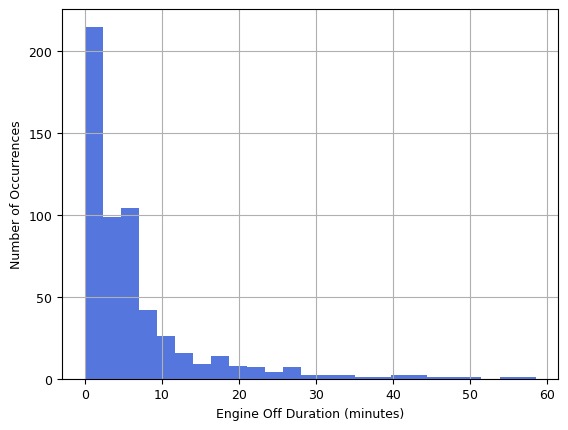

In [79]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})

# Plot histogram for 'site_wait_time_minutes' column
plt.hist(engine_off_summary_df[
    engine_off_summary_df.engine_off_duration_minutes < 59
]['engine_off_duration_minutes'], bins=25, color='#5576ddff')

# Adding labels and title
plt.grid()
plt.xlabel('Engine Off Duration (minutes)')
plt.ylabel('Number of Occurrences')

# Show plot
plt.show()

In [80]:
len(engine_off_summary_df[
    engine_off_summary_df.engine_off_duration_minutes < 59
])

568

In [81]:
len(engine_off_summary_df[
    engine_off_summary_df.engine_off_duration_minutes < 30
]) / len(engine_off_summary_df[
    engine_off_summary_df.engine_off_duration_minutes < 59
]) * 100

97.1830985915493

In [83]:
len(engine_off_summary_df[
    engine_off_summary_df.engine_off_duration_minutes < 25
]) / len(engine_off_summary_df[
    engine_off_summary_df.engine_off_duration_minutes < 59
]) * 100

95.77464788732394

In [ ]:
# Examples to check manually
engine_off_summary_df[
    (engine_off_summary_df.engine_off_duration_minutes > 25) &
    (engine_off_summary_df.engine_off_duration_minutes < 59)
]

,docket_id,engine_off_section_id,engine_off_start,engine_off_end,engine_off_duration_minutes
10,Cemex--1026184912,399.0,2024-11-20 10:48:24+00:00,2024-11-20 11:22:40+00:00,34.266667
27,Cemex--1026189757,512.0,2024-11-20 13:18:49+00:00,2024-11-20 13:45:44+00:00,26.916667
110,Cemex--1026213308,61.0,2024-11-21 16:12:30+00:00,2024-11-21 16:40:15+00:00,27.750000
118,Cemex--1026218610,256.0,2024-11-22 08:58:48+00:00,2024-11-22 09:25:33+00:00,26.750000
126,Cemex--1026221122,196.0,2024-11-22 10:46:42+00:00,2024-11-22 11:28:09+00:00,41.450000
169,Cemex--1026228862,404.0,2024-11-22 14:04:55+00:00,2024-11-22 14:55:55+00:00,51.000000
171,Cemex--1026228932,316.0,2024-11-22 14:23:09+00:00,2024-11-22 14:51:04+00:00,27.916667
172,Cemex--1026229044,505.0,2024-11-22 12:17:38+00:00,2024-11-22 12:52:53+00:00,35.250000
234,Cemex--1026239092,300.0,2024-11-25 09:43:21+00:00,2024-11-25 10:11:46+00:00,28.416667
238,Cemex--1026239709,306.0,2024-11-25 09:41:27+00:00,2024-11-25 10:23:15+00:00,41.800000
